In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import ollama

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data_path = '/content/drive/MyDrive/University/Shimmy/ShimmyData.xlsx'
data_path = 'raw_data.csv'
df = pd.read_csv(data_path)

In [7]:
df.head()

,Text,Category
0,"I really like mcdonalds, but i know it's unhea...",1
1,"Yes, well done! Absolutely rooting for you!",1
2,Deep sea diving is my new favourite interest!,1
3,The sound of the birds at this time of year re...,1
4,Big game this weekend guys. Let's go!,1


In [8]:
# Reshape DataFrame
# df_melted = df.melt(id_vars=["Text"], var_name="Category", value_name="Value").dropna()
# # Select only required columns and reset index
# df = df_melted[["Text", "Value"]].rename(columns={"Value": "Category"}).reset_index(drop=True)

df['Category'] = df['Category'].astype(int)

In [11]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [12]:
def display_metrics(ytrue, ypred):
  print("Accuracy Score: ", accuracy_score(ytrue, ypred))
  print(classification_report(ytrue, ypred))
  sns.heatmap(confusion_matrix(ytrue, ypred), annot=True, fmt='g')

In [13]:
df['Category'].value_counts()

Category
1    210
4    142
3    130
5    129
2    125
Name: count, dtype: int64

In [14]:
# Combine 1 & 2 as 1 , 2, and 4 & 5 as 3
df['Label'] = df['Category'].apply(lambda x: 1 if x in [1, 2] else (3 if x in [4, 5] else 2))
df['Label'].value_counts()

Label
1    335
3    271
2    130
Name: count, dtype: int64

### Roberta Classifier

In [24]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax


# MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
MODEL2 = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL2)
config = AutoConfig.from_pretrained(MODEL2)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL2)
#model.save_pretrained(MODEL)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [25]:
def get_scores(text):
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  return scores

In [26]:
for index, row in df.iterrows():
    text = row['Text']
    scores = get_scores(text)
    df.at[index, 'NegativeScore'] = scores[0]
    df.at[index, 'NeutralScore'] = scores[1]
    df.at[index, 'PositiveScore'] = scores[2]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [27]:
columns = list(df.columns)

for i in range(-3, 0, 1):
  print(columns[i])
  display(df.groupby('Label')[columns[i]].describe())
  print()

NegativeScore


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
1,335.0,0.413699,0.384266,0.008675,0.041898,0.279136,0.870660,0.966045
2,130.0,0.725031,0.254821,0.048070,0.586535,0.850023,0.914251,0.955535
3,271.0,0.760521,0.267782,0.019750,0.684875,0.900201,0.935933,0.965267



NeutralScore


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
1,335.0,0.256990,0.207035,0.021331,0.075770,0.202254,0.409087,0.797947
2,130.0,0.173090,0.147188,0.031342,0.066696,0.102958,0.319133,0.595355
3,271.0,0.157586,0.179002,0.022484,0.045541,0.076330,0.197224,0.827091



PositiveScore


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
1,335.0,0.329311,0.323976,0.010281,0.024424,0.180378,0.630307,0.946941
2,130.0,0.101879,0.180473,0.013123,0.020445,0.033020,0.072777,0.802663
3,271.0,0.081894,0.137571,0.009367,0.017113,0.025578,0.062863,0.852323


In [28]:
def classify_sentiment(row):
    max_score = max(row['NegativeScore'], row['NeutralScore'], row['PositiveScore'])
    if max_score == row['PositiveScore']:
        return 1
    elif max_score == row['NeutralScore']:
        return 2
    else:
        return 3

# Apply classification
ypred = df.apply(classify_sentiment, axis=1)

Accuracy Score:  0.49184782608695654
              precision    recall  f1-score   support

           1       0.87      0.36      0.51       335
           2       0.07      0.06      0.07       130
           3       0.48      0.86      0.61       271

    accuracy                           0.49       736
   macro avg       0.47      0.43      0.40       736
weighted avg       0.59      0.49      0.47       736



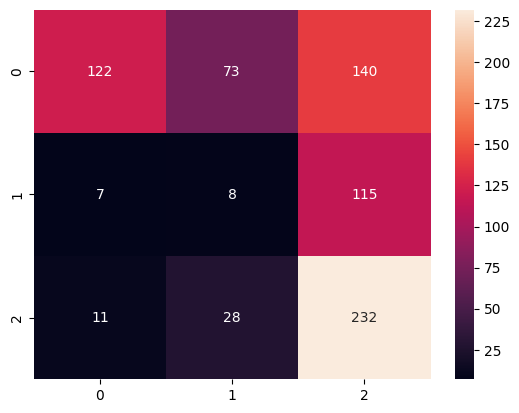

In [29]:
display_metrics(df['Label'], ypred)

### Gemma3

In [19]:
# Define a function to classify text
def classify_with_ollama(text):
    prompt = f"""
    Classify the following text into one of the five categories (1 to 5):
    - Category 1: Safe / Not Harmful
    - Category 2: Slightly negative
    - Category 3: Moderately or Strongly negative

    Text: "{text}"

    Respond with only a single integer from 1 to 3.
    """
    
    response = ollama.chat(model="gemma3:4b", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"].strip()  # Extract response

In [20]:
ypred = df['Text'].apply(classify_with_ollama)
ypred = ypred.astype(int)

Accuracy Score:  0.5190217391304348
              precision    recall  f1-score   support

           1       0.98      0.34      0.50       335
           2       0.01      0.01      0.01       130
           3       0.54      0.99      0.70       271

    accuracy                           0.52       736
   macro avg       0.51      0.44      0.40       736
weighted avg       0.65      0.52      0.49       736



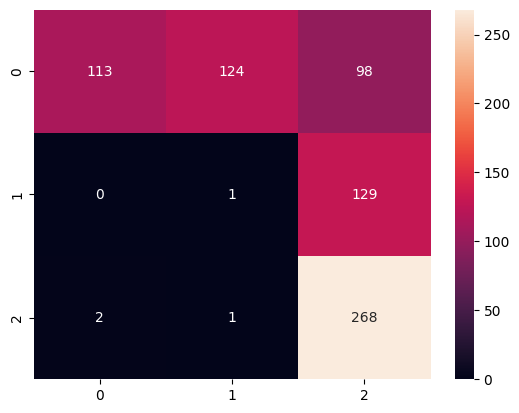

In [32]:
display_metrics(df['Label'], ypred)

### Llama3

In [33]:
# Define a function to classify text
def classify_with_llama(text):
    prompt = f"""
    Classify the following text into one of the five categories (1 to 5):
    - Category 1: Safe / Not Harmful
    - Category 2: Slightly negative
    - Category 3: Moderately or Strongly negative

    Text: "{text}"

    Respond with only a single integer from 1 to 3.
    """
    
    response = ollama.chat(model="llama3.1:8b", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"].strip()  # Extract response

In [34]:
ypred = df['Text'].apply(classify_with_llama)
ypred = ypred.astype(int)

display_metrics(df['Label'], ypred)

ValueError: invalid literal for int() with base 10: '1\n\nThe text is humorous and non-threatening.'